In [1]:
%matplotlib inline

import os

import gym
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

from models.vae import get_vae
from models.rnn import get_rnn

# Visualize VAE Recreation

#### Set these variables to indicate which autoencoder to visualize

In [2]:
data_shape = (144, 144, 3)
latent_dim = 64
data_path = 'environments/skiing/data/1127041855.npz'
vae_checkpoint_path = 'environments/skiing/checkpoints/vae.h5'
num_images = 5
output_file_vae = 'skiing_vae.png'

In [3]:
# vae = get_vae(data_shape, latent_dim)
vae = get_vae(data_shape, latent_dim,
                  filters=[16, 32, 64, 128, 256],
                  kernels=[4, 4, 4, 4, 4],
                  strides=[2, 2, 2, 2, 2],
                  deconv_filters=[256, 128, 64, 32, 16, 3],
                  deconv_kernels=[2, 5, 4, 4, 5, 4],
                  deconv_strides=[2, 2, 2, 2, 2, 2])
vae.load_weights(vae_checkpoint_path)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
obs = np.load(data_path)['obs'] / 255
np.random.shuffle(obs)
obs = obs[:num_images]
predictions = vae.predict(obs)

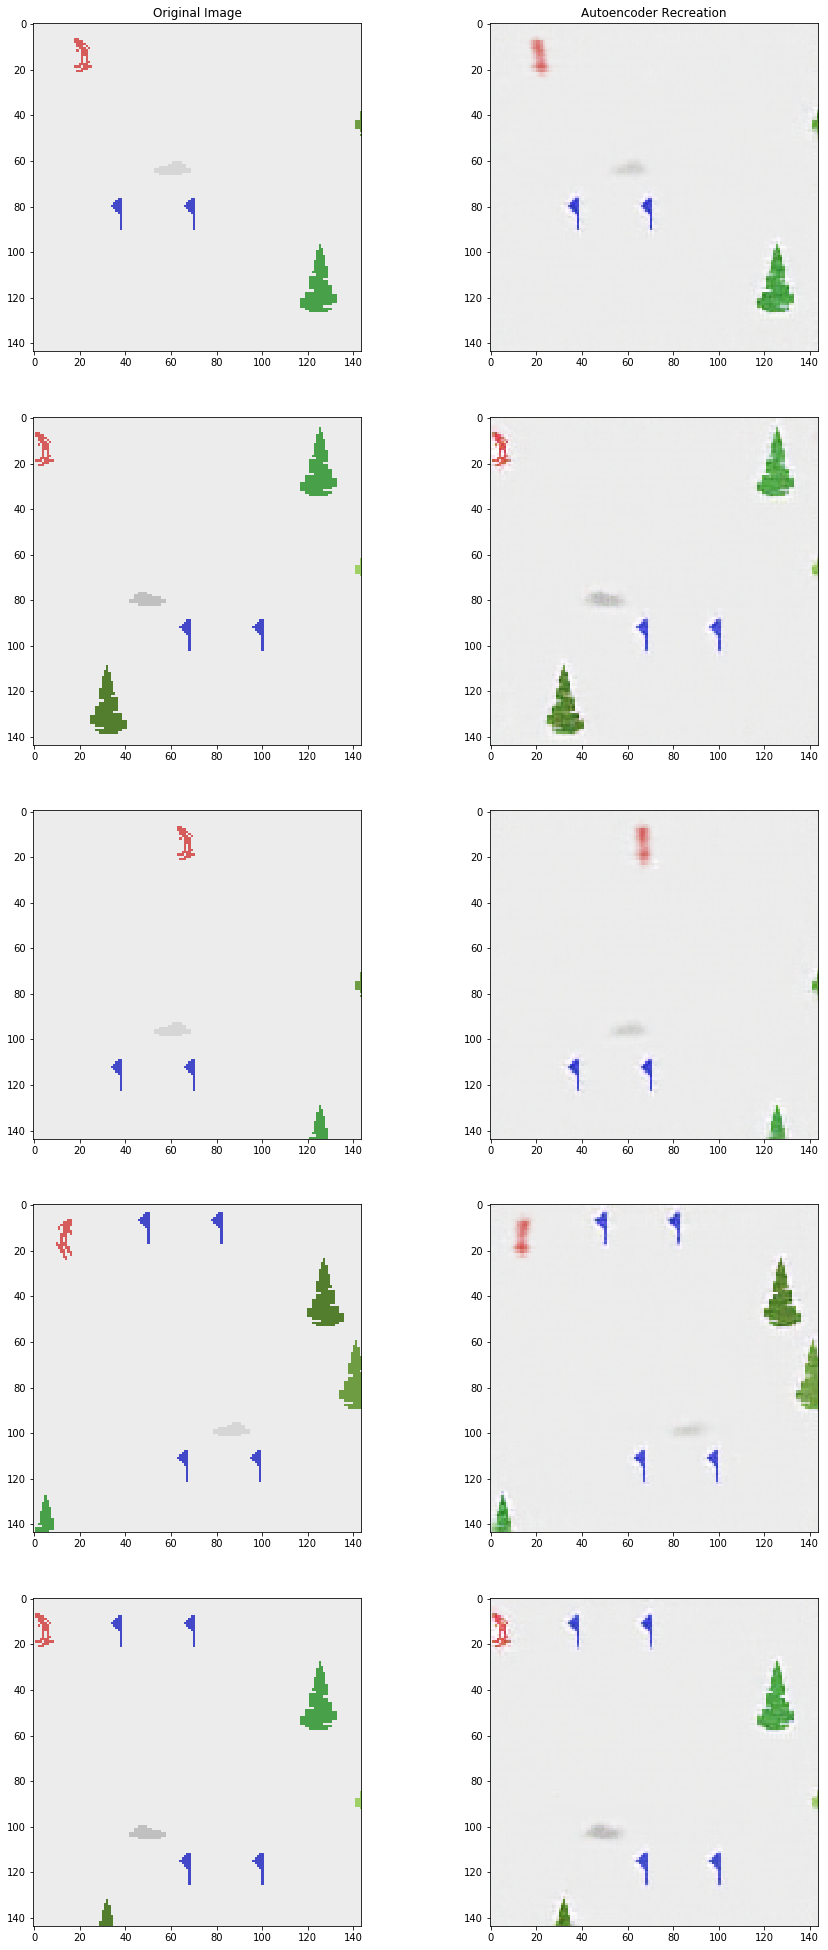

In [19]:
fig, axes = plt.subplots(num_images, 2, figsize=(15, 35))
axes[0][0].set_title('Original Image')
axes[0][1].set_title('Autoencoder Recreation')
for ax, im, gen in zip(axes, obs, predictions):
    ax[0].imshow(im, interpolation='nearest')
    ax[1].imshow(gen, interpolation='nearest')
plt.savefig(output_file_vae)

# Visualize RNN Prediction

#### Assuming correct VAE variables were set above, just set these to indicate which RNN to use

In [44]:
rnn_checkpoint_path = 'environments/skiing/checkpoints/rnn.h5'
output_file_rnn = 'skiing_rnn.png'
offset = 300
num_images = 5
action_dim = 1
series_path = 'environments/skiing/data/series.npz'

In [17]:
encoder = Model(inputs=vae.input,
                outputs=vae.get_layer('encoder').output)
decoder = Model(inputs=vae.get_layer('decoder').input,
                outputs=vae.get_layer('decoder').output)

In [20]:
rnn_train, rnn_infer = get_rnn((None, latent_dim + action_dim), output_sequence_width=latent_dim)
rnn_train.load_weights(rnn_checkpoint_path)

In [45]:
raw_data = np.load(series_path)
obs = raw_data['obs'].astype(np.float) / 255.
actions = raw_data['action']
obs = obs[offset:offset+num_images+1]
actions = actions[offset:offset+num_images+1]

FileNotFoundError: [Errno 2] No such file or directory: 'environments/skiing/data/series.npz'

In [35]:
z_true = encoder.predict(obs)[-1]
rnn_input = np.column_stack([z_true, np.expand_dims(actions, axis=-1)])[:-1]
# FOR SKIING
# rnn_input = np.expand_dims(rnn_input, axis=0)
rnn_input = np.reshape(rnn_input, (-1, 1, latent_dim+action_dim))
z_pred = rnn_train.predict(rnn_input)

In [36]:
# Sample predictions
num_mixtures = 5
output_sequence_width = 32
# Flattened output sequences and mixtures
flat = output_sequence_width*num_mixtures
# Get number of sequences
rollout = np.shape(z_pred)[1]
# Extract flattened variables
logpis_flat = z_pred[:,:,:flat]
mus_flat = z_pred[:,:,flat:flat*2]
sigmas_flat = z_pred[:,:,flat*2:flat*3]
sigmas_flat.shape
# Reshape to (batch, time, num_mixtures, output_sequence_width)
shape = [-1, rollout, num_mixtures, output_sequence_width]
logpis = np.reshape(logpis_flat, shape)
mus = np.reshape(mus_flat, shape)
sigmas = np.reshape(sigmas_flat, shape)
# Tempearture stuff
temperature = 0.7
logpistemp = np.copy(logpis)/temperature
logpistemp -= logpistemp.max()
pistemp = np.exp(logpistemp)
pistemp /= pistemp.sum(axis=2, keepdims=True)
pitemp = pistemp[:,0,:,:]
mu = mus[:,0,:,:]
sigma = sigmas[:,0,:,:]

In [37]:
def get_pi_idx(x, pdf):
    # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print('error with sampling ensemble')
    return -1

In [41]:
pi_idx = np.zeros((pitemp.shape[0], latent_dim))
chosen_mu = np.zeros((pitemp.shape[0], latent_dim))
chosen_sigma = np.zeros((pitemp.shape[0], latent_dim))
for i in range(pitemp.shape[0]):
    for j in range(32):
        idx = get_pi_idx(np.random.rand(), pitemp[i][:,j])
        pi_idx[i,j] = idx
        chosen_mu[i,j] = mu[i][idx][j]
        chosen_sigma[i,j] = sigma[i][idx][j]

rand_gaussian = np.random.normal(size=(pitemp.shape[0], latent_dim))*np.sqrt(temperature)
next_z = chosen_mu+chosen_sigma*rand_gaussian

In [42]:
predictions = decoder.predict(next_z)
predictions_real = decoder.predict(z_true)

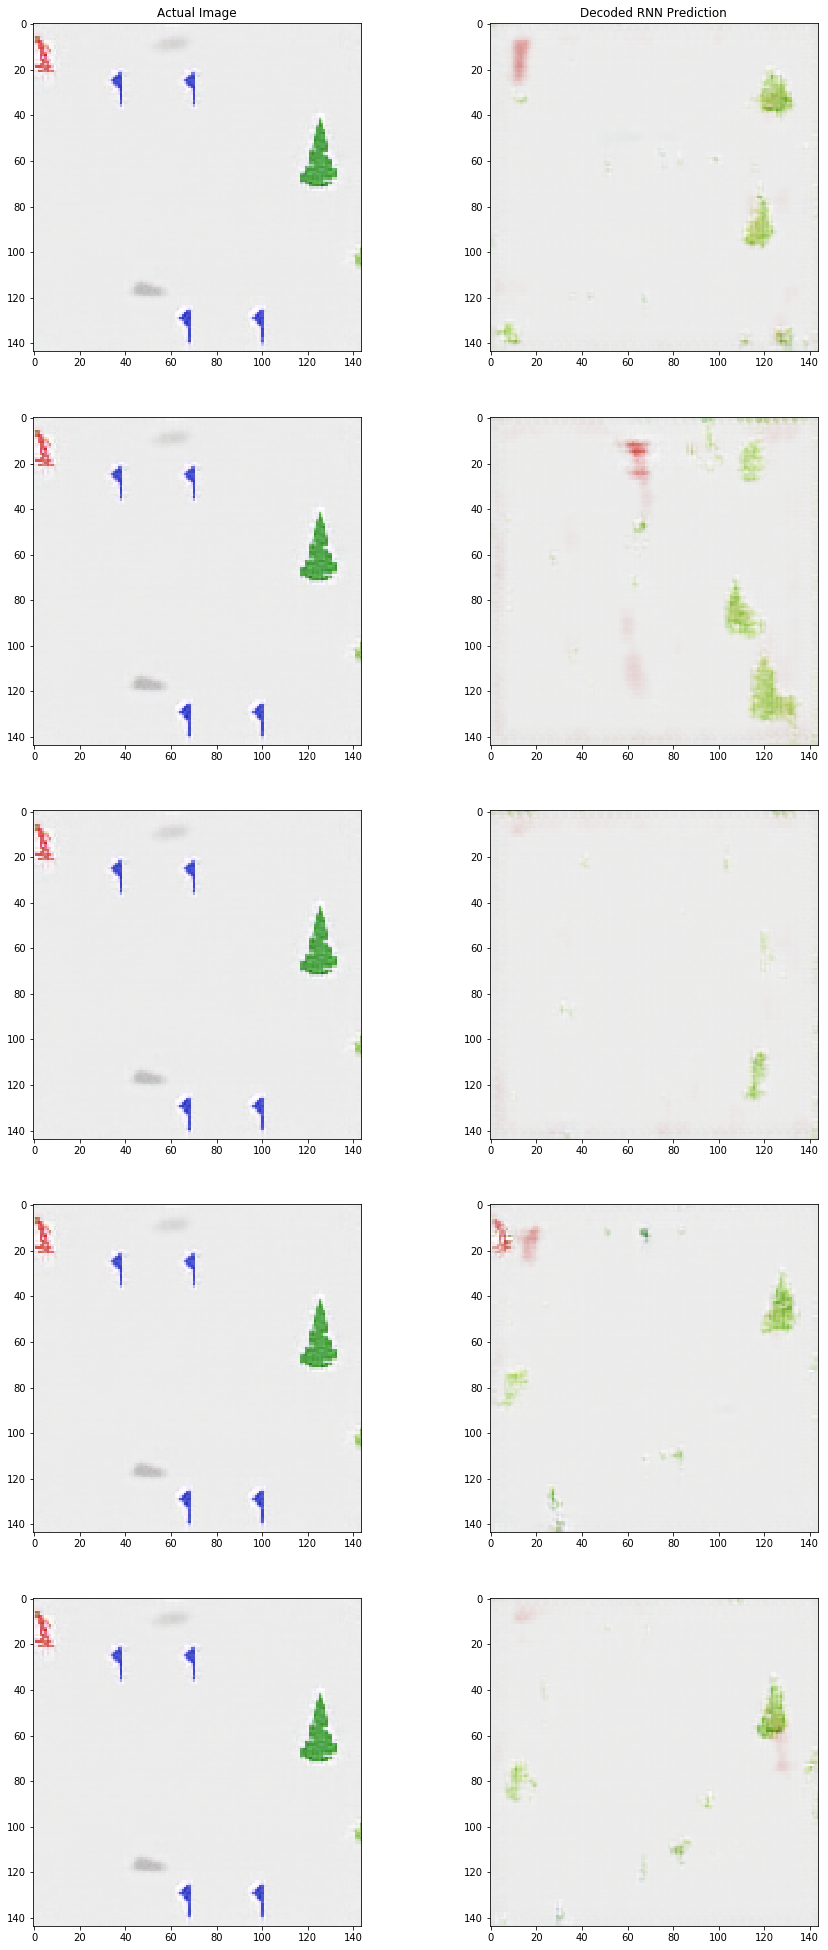

In [43]:
fig, axes = plt.subplots(num_images, 2, figsize=(15, 35))
axes[0][0].set_title('Actual Image')
axes[0][1].set_title('Decoded RNN Prediction')
for ax, im, gen in zip(axes, predictions_real[1:], predictions):
    ax[0].imshow(im, interpolation='nearest')
    ax[1].imshow(gen, interpolation='nearest')
plt.savefig(output_file_rnn)